# Stochastic Kronecker Graphs - A Finite Mixture Model Approach


We propose the mixture model below for stochastic kronecker graph solutions

<img src="mix_model_1.png" style="width: 30%" align="right">

- Notation Glossary:  
    - $K$ : Number of kronecker layers or products to obtain $\Phi$
    - $N$ : Number of rows (=columns)
    - $\gamma_\alpha$, $\gamma_\beta$ : Log-Normal distributions 
    - $\alpha_k$, $\beta_k$ : Parameters for K number of Beta distributions
    - $\mu_k$ : k'th Beta distribution
    - $\theta_{ij}$ : (i,j)'th element of k'th basis matrix theta
    - $\Sigma$ : Scalar addition
    - $\epsilon$ : Noise scale or amplitude
    - $n_{ij}$ : Noise value being added to the the (i,j)'th element
    - $Z$ : Sequence of basis classes that need to be kronecker multiplied
    - $U$ : Categorical distribution parameters for basis classes
    - $\Phi$ : Distribution over adjacency matrices of graphs (Bernoulli Batch)
    - $G$ : Adjacency matrix of observed graph

##### Further questions, thoughts and ideas
1. The noise addition could be to the kronecker result, not to each theta. This would mean that whatever the type of $\Phi$ we learn or use, we cannot be more certain than the variance of the noise we add to the kronecker product. This will stop islands from occuring. (How do we write that in a graphical representation?)

2. Should we be learning a transition matrix for $\theta_{ij}$ elements? There ought to be some model over the structure of $\theta^{(k)}_c$. However, a transition is a valid model for only sequences, this is not a sequence...

3. The permutation noise does not seem to be handled by this, at least by looking at samples. How do we model that?

In the following, we will implement our mixture model and generate examples from it.

In [1]:
# All imports
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Methods being used:

In [2]:
def kronecker_product(mat1, mat2):
    m1 = tf.shape(mat1)[0]
    n1 = tf.size(mat1) // m1
    m2 = tf.shape(mat2)[0]
    n2 = tf.size(mat2) // m2
    mat2_rsh =tf.reshape(mat1, [1, m1, 1, n1])
    mat1_rsh =tf.reshape(mat2, [m2, 1, n2, 1])
    return tf.reshape(mat1_rsh*mat2_rsh, [m1 * m2, n1 * n2])

In [3]:
def addNoise2Mat(mat, mean, std, NRMLZ=True):
    # Set the seed so the results are reproducible.
    np.random.seed(123)
    # Make distribution, sample and add
    p_eta = tfd.Normal(loc=mean, scale=std, name='AdditiveEdgeNoise')
    eta_c = p_eta.sample(tf.shape(mat))
    mat_noise = mat + eta_c
    # Make sure values do not run off
    # Clip values out of [0,1]
    if NRMLZ:
        mat_noise_nrml   = tf.maximum(tf.minimum(mat_noise,1),0)
        return mat_noise_nrml
    else:
        return mat_noise

### Parameters:

In [4]:
# Graph parameters
theta_shape_   = np.array([3,3])
NoiseScale_    = 0.5

# Run Parameters
PRINTS        = False
NumSamples    = 5
K_            = 5
kk            = np.array(5,dtype=float)

### Mixture Model implementation:

Our mixture model still uses the layered network structure proposed in the work of Stochastic Kronecker Graphs. It relaxes the assumption that the $\theta$ at every kronecker layer is the same. Which means the following:

* $G$ is the adjacency matrix of a large network whose size is $\scriptsize N^K \times N^K$
* $G \sim \Phi$ which is a set of independent binomial distributions on the occurrence of edges
* We assume a set of $\theta_k$ make up the $\Phi$ through successive kronecker products
    
    $\Phi   = \theta^{(1)}\otimes \theta^{(2)} \otimes \dots \theta^{(k)} \dots \otimes \theta^{(K)}$
* If we assume the sizes of each of these $\theta^{(k)}$ are fixed to $N\times N$, then $\Phi_{N^K\times N^k}$
* Further according to our mixture model we allow each $\theta^{(k)}$ to be of a particular "basis" or "class". That is  $\theta^{(k)} \in [\theta_1, \theta_2, \dots, \theta_c, \dots, \theta_C]_{C\rightarrow\infty}$ because we want to model that $\theta^{(k)}$ is drawn from a continuous distribution as shown in our mixture model.
    
    For example $\theta^{(2)}_4$ is a basis $\theta$ belonging to a class with label 4 and has the index 2 in the sequence of kronecker multiplications to obtain $\Phi$


In the following sections we implement the above mixture model in pieces. There are 2 main parts: 
1. <b>Sampling for Bases</b>: decides which are the bases to k-multiply
2. <b>Partition selection</b>: decides which basis to to k-multiply to which order

### 1. Sampling for Bases:
We propose two log-normal distributions which generate $\alpha_k$ and $\beta_k$ values for every $k \in K$

In [5]:
# Sample from separate log-normal distributions to get K number of values for alpha and beta
# Setup parameters
sig_a = tf.placeholder_with_default([1.0], [1]) # skew parameter TUNE
sig_b = tf.placeholder_with_default([1.0], [1]) # skew parameter TUNE
mean_a  = tf.placeholder_with_default([0.0], [1]) # mean parameter TUNE
mean_b  = tf.placeholder_with_default([0.0], [1]) # mean parameter TUNE
# Make log-normal distributions
# alpha_batch_shape = beta_batch_shape    = K
gamma_a   = tfd.LogNormal(loc=mean_a, scale=sig_a, name="LogNormal-Alphas")
gamma_b   = tfd.LogNormal(loc=mean_b, scale=sig_b, name="LogNormal-Betas")
# Sample from these distributions
alpha_batch   = gamma_a.sample(K_)
beta_batch    = gamma_b.sample(K_)

We build a batch of $K$ Beta distributions

In [6]:
# Build K number of Beta distributions from alpha and beta values
mu_batch   = tfd.Beta(alpha_batch, beta_batch, name='kBetaDistb')

Each of the $K$ Beta distributions produce the $N\times N$ number of $\theta_{ij}$ elements for their corresponding $\theta^{(k)}_c$

In [7]:
# Get theta_ij values for every theta_k from the corresponding mu_k
theta_k_shape   = tf.placeholder(tf.int32, (2,), name="theta_k_shape")
theta_c_set     = tf.squeeze(mu_batch.sample(sample_shape=theta_k_shape, name="theta_class_set"), axis=-1)

### 2. Partition selection:
This is implemented using a Dirichlet sequence generation.
    
[TODO] Sample this also from somewhere -- LogNormal?

In [8]:
# Set parameter U
# U   = np.ones(K_, dtype=np.float64) # Uniform
U_       = np.array(range(K_), dtype=np.float64)+1 # Ramped
print('Alphas = {}'.format(U_))
NumSeqs   = 1

Alphas = [1. 2. 3. 4. 5.]


[TODO] Try Multinomial, Dirichlet, Chinese Restaurant Process

In [9]:
# Build Dirichlet-Multinomial distribution
count    = tf.placeholder(tf.float64)
U        = tf.placeholder(tf.float64)
seq_dist = tfd.DirichletMultinomial(count, U_, name='Partition_selector')

In [10]:
# Sample from built distribution
Z   = seq_dist.sample(NumSeqs)

[TODO]: Write this part to be part of same graph

[TODO]: Conditional TF graph building? How? Gating using gating sequence of length $K\times C$?

In [11]:
p_sess   = tf.Session()
[Z_]     = p_sess.run([Z], 
                     feed_dict={
                         U: U_,
                         count: kk
                     })
Z_   = Z_.flatten()
print('Partition sequence is {}'.format(Z_))

Partition sequence is [0. 1. 0. 2. 2.]


In [12]:
# Make the sequence of classes used
theta_class_Seq   = [k for k,z in zip(range(K_),Z_) for i in range(int(z))]
print('Class sequence is {}'.format(theta_class_Seq))

Class sequence is [1, 3, 3, 4, 4]


### Compose Kronecker Graph from bases and sequence:
Kronecker multiply to obtain the threshold values for $\Phi$

In [13]:
NoiseScale   = tf.placeholder_with_default(0.01,[])   
isFirst      = True
# Analytics
theta_Sequence  = []
phi_progress    = []
for k in range(0,K_):
    for i in range(int(Z_[k])):
        # Select current theta in the kronecker product chain
        ktheta_c   = theta_c_set[...,k]
        phi_progress.append(ktheta_c)   # Progression of Phi
        if isFirst:
            phi_batch   = ktheta_c
        # Add noise to the product
#         ktheta_c   =  addNoise2Mat(theta_c_set[...,k], 0.0, NoiseScale)
        phi_batch   =  addNoise2Mat(phi_batch, 0.0, NoiseScale)
    
        phi_progress.append(phi_batch)   # Progression of Phi
        if not isFirst:
            # Do kronecker product with current theta
            phi_batch   = kronecker_product(phi_batch, ktheta_c)
        # Reset flag
        isFirst     = False
        # Store for analysing 
        theta_Sequence.append(ktheta_c)  # Actual thetas
        phi_progress.append(phi_batch)   # Progression of Phi

Sample from the $\Phi$:

In [14]:
Phi   = tfd.Bernoulli(probs=phi_batch, name='Phi')
G_c   = Phi.sample(NumSamples)

### Run Session for Sampling

In [15]:
sess = tf.Session()
# Run the session
[s_G_c,  s_phi_batch, s_theta_c_set, 
 s_theta_Sequence, s_phi_progress] = sess.run([G_c, phi_batch, theta_c_set, 
                                               theta_Sequence, phi_progress],
                                           feed_dict={
                                               NoiseScale:NoiseScale_,
                                               theta_k_shape:theta_shape_,
                                           })

In [16]:
# All prints
if PRINTS:
    print(s_G_c.shape)
    print(s_G_c)

    print(s_theta_c_set.shape)
    print(s_theta_c_set)

    print(s_phi_batch)

    print(s_theta_Noised)
    
    print('Partition of bases is: {}'.format(Z_))

### Plotting

Below are all the bases $\theta_c$ that have been sampled. (Total set of classes that our Bernoulli Batch Kronecker Graph $\Phi$ is composed of.)

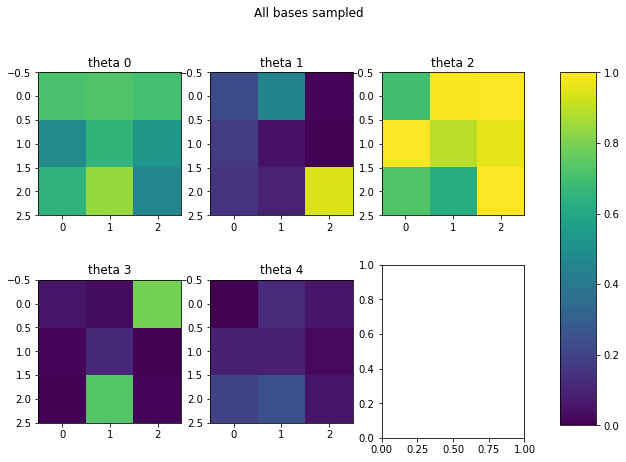

In [26]:
r = int(np.floor(np.sqrt(K_)))
c = int(np.ceil(float(K_)/r))
f1, axes1   = plt.subplots(nrows=r, ncols=c)
plt.rcParams["figure.figsize"] = (8, 5) # To increase or decrease the sizes of subplots
f1.suptitle('All bases sampled')
for i in range(0,K_):
    im = axes1.flat[i].imshow(s_theta_c_set[...,i], vmax=1.0, vmin=0.0)
    axes1.flat[i].set_title('theta {}'.format(i))
    
# Colorbar
f1.subplots_adjust(right=0.8)
cbar_ax = f1.add_axes([0.85, 0.15, 0.05, 0.7])
f1.colorbar(im, cax=cbar_ax)
plt.rcParams["figure.figsize"] = (8, 5) # To increase or decrease the sizes of subplots
plt.show()

Actual $\theta_c$ sequence used to make $\Phi$ :

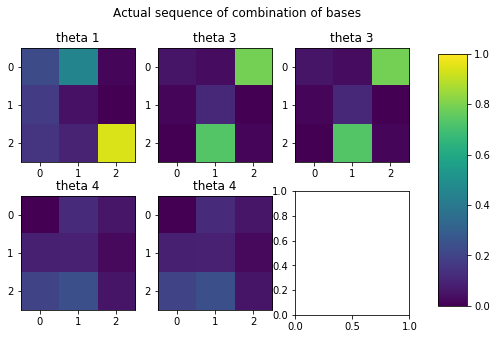

In [18]:
f2, axes2   = plt.subplots(nrows=r, ncols=c)
plt.rcParams["figure.figsize"] = (8,5) # To increase or decrease the sizes of subplots
f2.suptitle('Actual sequence of combination of bases')
for i in range(0,K_):
    im = axes2.flat[i].imshow(s_theta_Sequence[i], vmax=1.0, vmin=0.0)
    axes2.flat[i].set_title('theta {}'.format(theta_class_Seq[i]))
    
# Colorbar
f2.subplots_adjust(right=0.8)
cbar_ax = f2.add_axes([0.85, 0.15, 0.05, 0.7])
f2.colorbar(im, cax=cbar_ax)
plt.show()

Shows the build progression of $\Phi$

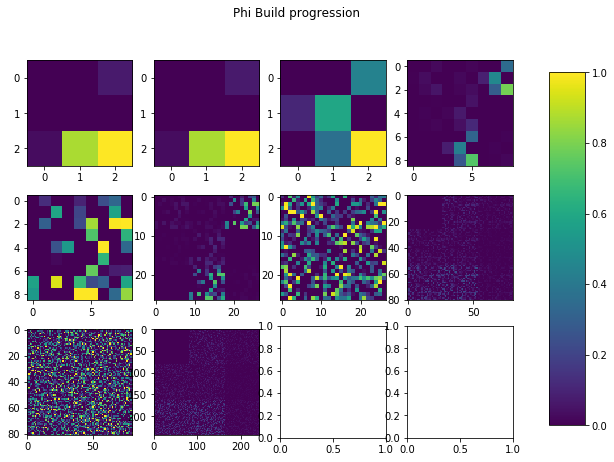

In [22]:
r1 = int(np.floor(np.sqrt(len(s_phi_progress))))
c1 = int(np.ceil(float(len(s_phi_progress))/r1))
f3, axes3   = plt.subplots(nrows=r1, ncols=c1)
plt.rcParams["figure.figsize"] = (8,5) # To increase or decrease the sizes of subplots
f3.suptitle('Phi Build progression')
for i in range(0,len(s_phi_progress)):
    im = axes3.flat[i].imshow(s_phi_progress[i], vmax=1.0, vmin=0.0)
    
# Colorbar
f3.subplots_adjust(right=0.8)
cbar_ax = f3.add_axes([0.85, 0.15, 0.05, 0.7])
f3.colorbar(im, cax=cbar_ax)
plt.show()

Final $\Phi$

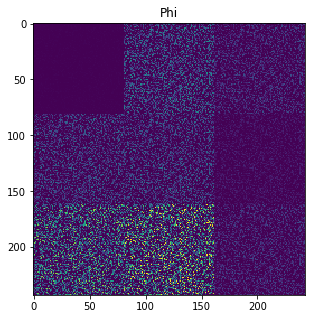

In [20]:
f4= plt.figure()
plt.title('Phi')
plt.imshow(s_phi_batch)
plt.show()

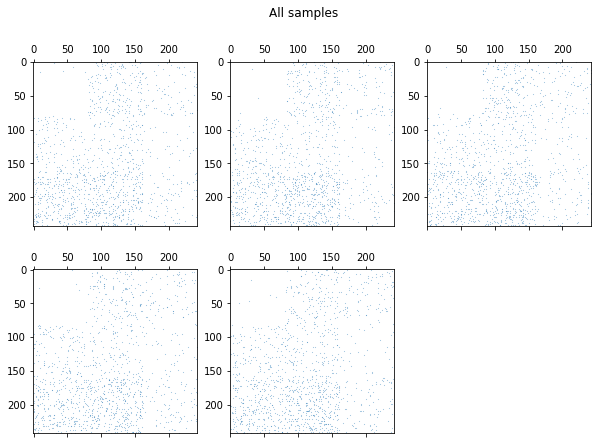

In [25]:
plt.figure
plt.suptitle('All samples')
r = np.floor(np.sqrt(NumSamples))
c = np.ceil(float(NumSamples)/r)
for i in range(0,NumSamples):
    plt.subplot(r,c,i+1)
    plt.spy(s_G_c[i,:], markersize=0.1)

plt.rcParams["figure.figsize"] = (10,7) # To increase or decrease the sizes of subplots

Note: K Should come from another source which computes how many kronecker products are needed.  
        
        K   = tf.placeholder(tf.int32) # Incorrect because cant unfurl as a graph on the fly
        
Q: How to write 2 or more sessions that can still be optimized using the same MCMC?